In [1]:
import numpy as np
import pandas as pd 
import os
from keras.models import Sequential, load_model
from keras.layers import (Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D,
                          BatchNormalization, Input, Conv2D, GlobalAveragePooling2D,concatenate,Concatenate,multiply, LocallyConnected2D, Lambda)
from keras.callbacks import ModelCheckpoint
from keras import metrics
from keras import backend as K
import keras
from keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras.applications import EfficientNetB7
import skimage.io
from skimage.transform import resize

from tqdm import tqdm
import PIL
from PIL import Image, ImageOps
import cv2
from sklearn.utils import class_weight, shuffle
from keras.losses import binary_crossentropy, categorical_crossentropy
#from keras.applications.resnet50 import preprocess_input
from keras.applications.densenet import DenseNet121,DenseNet169,preprocess_input
import keras.backend as K
import tensorflow as tf
from sklearn.metrics import f1_score, fbeta_score, cohen_kappa_score

import keras.callbacks as callbacks
from keras.callbacks import Callback
get_ipython().run_line_magic('config', 'InlineBackend.figure_format="svg"')
get_ipython().run_line_magic('matplotlib', 'inline')

import warnings
warnings.filterwarnings("ignore")
SIZE = 224
NUM_CLASSES = 2
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, load_model
from keras.layers import Embedding, LSTM, Dropout, Dense, Input, Bidirectional, Flatten, Conv2D, MaxPooling2D, concatenate, Conv1D, MaxPooling1D
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping
from keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten, concatenate
from keras.models import Model



In [2]:
from sklearn.model_selection import train_test_split


In [3]:
from PIL import Image
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler


def get_num_input():
    df = pd.read_csv('/DATA/akanksha_2021cs39/audiodataset.csv')
    df = df.drop(['filename'],axis=1)
    columns = list(df.columns)
    features = columns[:-1]
    cls_name = columns[-1]
    X = np.zeros((len(df), len(features)))
    Y = list()
    for i, row in df.iterrows():
        X[i] = row[features]                    
        Y.append(row[cls_name])

    return (X, Y)
X_num, Y = get_num_input()
encoder = LabelEncoder()
Y = encoder.fit_transform(Y)
X_audio_train, X_audio_test, y_audio_train, y_audio_test = train_test_split( X_num, Y, test_size=0.2,random_state=42)
#Scaling the Feature columns
#scaler = StandardScaler()
#X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float)

#def get_img_input():
    #df = pd.read_csv('/DATA/akanksha_2021cs39/visualdata.csv')
    #X_img = np.zeros((len(df), 224, 224)) # change as per image size
    #Y = list()
    #for i, row in df.iterrows():
        #X_img[i] = np.array(Image.open(row['X_img']))
        #Y.append(row['class'])

    #return (X_img, Y)
    
#X_img, Y_img = get_img_input() # use one of the Ys
# X feature normalization, convert Y to one-hot representation

In [4]:
from PIL import Image
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
def get_img_input():
    df = pd.read_csv('/DATA/akanksha_2021cs39/visualdata.csv')
    columns = list(df.columns)
    features = columns[:-1]
    cls_name = columns[-1]
    X = np.zeros((len(df), len(features)))
    Y = list()
    for i, row in df.iterrows():
        X[i] = row[features]                    
        Y.append(row[cls_name])

    return (X, Y)
X_img, Y_img = get_img_input()
encoder = LabelEncoder()
Y_img = encoder.fit_transform(Y_img)
X_img_train, X_img_test, y_img_train, y_img_test = train_test_split( X_img, Y_img, test_size=0.2,random_state=42)

In [5]:
y_train=y_img_train ## both audio and video samples are synchronized so both have same levels that is why
                                                         #initialized here with one (audio or video) label.
y_test=y_img_test

In [6]:
print(X_audio_train.shape)
print(X_img_train.shape)
print(X_audio_test.shape)
print(X_img_test.shape)
print(y_audio_train.shape)
print(y_img_train.shape)
print(y_audio_test.shape)
print(y_img_test.shape)

(403, 133)
(403, 50177)
(101, 133)
(101, 50177)
(403,)
(403,)
(101,)
(101,)


In [7]:
from keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten, concatenate
from keras.models import Model
import numpy as np
from keras import regularizers
from keras.layers import Dropout 
def compile_model():
    img_input = Input(shape=(50177,)) 
    ## branch 1 with image input
    x = Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01))(img_input)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = Dropout(0.3)(x)
    out_a = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    
    #x = MaxPooling2D((2, 2))(x)
    #x = Flatten()(x)
    #out_a = Dense(64)(x)

    num_input = Input(shape=(133,))        ## branch 2 with numerical input
    x1 = Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01))(num_input)
    x1 = Dropout(0.3)(x1)
    x1 = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x1)
    x1 = Dropout(0.3)(x1)
    x1 = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x1)
    x1 = Dropout(0.3)(x1)
    x1 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x1)
    x1 = Dropout(0.3)(x1)
    x1 = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x1)
    x1 = Dropout(0.3)(x1)
    out_b = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x1)

    concatenated = concatenate([out_a, out_b])    ## concatenate the two branches
    out = Dense(1, activation='sigmoid')(concatenated)
    model = Model([img_input, num_input], out)
    adam = Adam(lr=0.001, decay=1e-5)
    print(model.summary())
    model.compile(loss="binary_crossentropy", optimizer=adam, metrics=["accuracy"])
    return model
    
    
    

### Just for sanity check

#print(model.predict(X))

In [8]:
    #img_input = Input(shape=(50177,)) 
    ## branch 1 with image input
    #x = Dense(8, activation='relu')(img_input)
    #out_a = Dense(16, activation='relu')(x)
    #x = MaxPooling2D((2, 2))(x)
    #x = Flatten()(x)
    #out_a = Dense(64)(x)

    #num_input = Input(shape=(133,))        ## branch 2 with numerical input
    #x1 = Dense(8, activation='relu')(num_input)
    #out_b = Dense(16, activation='relu')(x1)

    #concatenated = concatenate([out_a, out_b])    ## concatenate the two branches
    #out = Dense(1, activation='sigmoid')(concatenated)
    #model = Model([img_input, num_input], out)
    #adam = Adam(lr=0.001, decay=1e-5)
    #print(model.summary())
    #model.compile(loss="binary_crossentropy", optimizer=adam, metrics=["accuracy"])
    #return model

In [9]:
model = compile_model()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50177)]      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 133)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 1024)         51382272    input_1[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 1024)         137216      input_2[0][0]                    
______________________________________________________________________________________________

In [10]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
history=model.fit([X_img_train, X_audio_train], y_train, batch_size=256, epochs=1000,
                            validation_data=([X_img_test, X_audio_test], y_test), callbacks=[es])

Epoch 1/1000
2/2 [==============================] - 3s 640ms/step - loss: 222.4454 - accuracy: 0.4839 - val_loss: 542.0692 - val_accuracy: 0.4455
Epoch 2/1000
2/2 [==============================] - 1s 346ms/step - loss: 738.0671 - accuracy: 0.5310 - val_loss: 132.9545 - val_accuracy: 0.5545
Epoch 3/1000
2/2 [==============================] - 1s 351ms/step - loss: 699.4656 - accuracy: 0.4913 - val_loss: 229.3535 - val_accuracy: 0.5545
Epoch 4/1000
2/2 [==============================] - 1s 386ms/step - loss: 662.7079 - accuracy: 0.5285 - val_loss: 283.6769 - val_accuracy: 0.5545
Epoch 5/1000
2/2 [==============================] - 1s 360ms/step - loss: 500.6738 - accuracy: 0.5856 - val_loss: 212.2653 - val_accuracy: 0.5545
Epoch 6/1000
2/2 [==============================] - 1s 372ms/step - loss: 592.6403 - accuracy: 0.5806 - val_loss: 144.8813 - val_accuracy: 0.6337
Epoch 7/1000
2/2 [==============================] - 1s 360ms/step - loss: 448.6396 - accuracy: 0.6377 - val_loss: 141.4814 -

2/2 [==============================] - 1s 336ms/step - loss: 33.6246 - accuracy: 0.7965 - val_loss: 31.1241 - val_accuracy: 0.8416
Epoch 114/1000
2/2 [==============================] - 1s 336ms/step - loss: 33.0159 - accuracy: 0.8412 - val_loss: 31.0422 - val_accuracy: 0.8020
Epoch 115/1000
2/2 [==============================] - 1s 331ms/step - loss: 32.6262 - accuracy: 0.8387 - val_loss: 30.9245 - val_accuracy: 0.7822
Epoch 116/1000
2/2 [==============================] - 1s 329ms/step - loss: 32.0905 - accuracy: 0.8089 - val_loss: 30.6393 - val_accuracy: 0.9307
Epoch 117/1000
2/2 [==============================] - 1s 329ms/step - loss: 32.3582 - accuracy: 0.8288 - val_loss: 30.5212 - val_accuracy: 0.9109
Epoch 118/1000
2/2 [==============================] - 1s 343ms/step - loss: 31.7572 - accuracy: 0.8362 - val_loss: 30.4373 - val_accuracy: 0.8812
Epoch 119/1000
2/2 [==============================] - 1s 336ms/step - loss: 31.6397 - accuracy: 0.8288 - val_loss: 30.3821 - val_accuracy: 

2/2 [==============================] - 1s 351ms/step - loss: 21.4771 - accuracy: 0.8759 - val_loss: 21.3725 - val_accuracy: 0.9208
Epoch 226/1000
2/2 [==============================] - 1s 312ms/step - loss: 21.3928 - accuracy: 0.8809 - val_loss: 21.3044 - val_accuracy: 0.9208
Epoch 227/1000
2/2 [==============================] - 1s 301ms/step - loss: 21.3237 - accuracy: 0.8908 - val_loss: 21.2307 - val_accuracy: 0.9208
Epoch 228/1000
2/2 [==============================] - 1s 313ms/step - loss: 21.2896 - accuracy: 0.8734 - val_loss: 21.1621 - val_accuracy: 0.9208
Epoch 229/1000
2/2 [==============================] - 1s 310ms/step - loss: 21.1860 - accuracy: 0.8958 - val_loss: 21.0919 - val_accuracy: 0.9208
Epoch 230/1000
2/2 [==============================] - 1s 305ms/step - loss: 21.1396 - accuracy: 0.8883 - val_loss: 21.0223 - val_accuracy: 0.9208
Epoch 231/1000
2/2 [==============================] - 1s 322ms/step - loss: 21.0641 - accuracy: 0.8883 - val_loss: 20.9541 - val_accuracy: 

2/2 [==============================] - 1s 324ms/step - loss: 16.4228 - accuracy: 0.8834 - val_loss: 16.3446 - val_accuracy: 0.9109
Epoch 338/1000
2/2 [==============================] - 1s 342ms/step - loss: 16.3953 - accuracy: 0.8859 - val_loss: 16.3056 - val_accuracy: 0.9208
Epoch 339/1000
2/2 [==============================] - 1s 311ms/step - loss: 16.3394 - accuracy: 0.8859 - val_loss: 16.2751 - val_accuracy: 0.9208
Epoch 340/1000
2/2 [==============================] - 1s 320ms/step - loss: 16.3509 - accuracy: 0.8759 - val_loss: 16.2446 - val_accuracy: 0.9208
Epoch 341/1000
2/2 [==============================] - 1s 312ms/step - loss: 16.2784 - accuracy: 0.8933 - val_loss: 16.2077 - val_accuracy: 0.9208
Epoch 342/1000
2/2 [==============================] - 1s 308ms/step - loss: 16.3072 - accuracy: 0.8685 - val_loss: 16.1815 - val_accuracy: 0.9208
Epoch 343/1000
2/2 [==============================] - 1s 314ms/step - loss: 16.2268 - accuracy: 0.8784 - val_loss: 16.1495 - val_accuracy: 

2/2 [==============================] - 1s 339ms/step - loss: 13.6591 - accuracy: 0.8859 - val_loss: 13.5653 - val_accuracy: 0.9208
Epoch 450/1000
2/2 [==============================] - 1s 288ms/step - loss: 13.6222 - accuracy: 0.8883 - val_loss: 13.5466 - val_accuracy: 0.9208
Epoch 451/1000
2/2 [==============================] - 1s 303ms/step - loss: 13.6104 - accuracy: 0.8859 - val_loss: 13.5374 - val_accuracy: 0.9208
Epoch 452/1000
2/2 [==============================] - 1s 281ms/step - loss: 13.5790 - accuracy: 0.8908 - val_loss: 13.5321 - val_accuracy: 0.9010
Epoch 453/1000
2/2 [==============================] - 1s 302ms/step - loss: 13.5510 - accuracy: 0.8933 - val_loss: 13.5125 - val_accuracy: 0.9010
Epoch 454/1000
2/2 [==============================] - 1s 298ms/step - loss: 13.5495 - accuracy: 0.8834 - val_loss: 13.4914 - val_accuracy: 0.9010
Epoch 455/1000
2/2 [==============================] - 1s 323ms/step - loss: 13.5216 - accuracy: 0.8883 - val_loss: 13.4714 - val_accuracy: 

2/2 [==============================] - 1s 290ms/step - loss: 12.0407 - accuracy: 0.8834 - val_loss: 11.9551 - val_accuracy: 0.9208
Epoch 562/1000
2/2 [==============================] - 1s 310ms/step - loss: 12.0279 - accuracy: 0.8908 - val_loss: 11.9530 - val_accuracy: 0.9208
Epoch 563/1000
2/2 [==============================] - 1s 285ms/step - loss: 12.0220 - accuracy: 0.8859 - val_loss: 11.9510 - val_accuracy: 0.9208
Epoch 564/1000
2/2 [==============================] - 1s 312ms/step - loss: 12.0035 - accuracy: 0.8883 - val_loss: 11.9519 - val_accuracy: 0.9208
Epoch 565/1000
2/2 [==============================] - 1s 315ms/step - loss: 11.9934 - accuracy: 0.8859 - val_loss: 11.9495 - val_accuracy: 0.9010
Epoch 566/1000
2/2 [==============================] - 1s 286ms/step - loss: 11.9851 - accuracy: 0.8958 - val_loss: 11.9390 - val_accuracy: 0.9010
Epoch 567/1000
2/2 [==============================] - 1s 292ms/step - loss: 11.9775 - accuracy: 0.8908 - val_loss: 11.9209 - val_accuracy: 

2/2 [==============================] - 1s 292ms/step - loss: 10.9698 - accuracy: 0.8809 - val_loss: 10.8753 - val_accuracy: 0.9208
Epoch 674/1000
2/2 [==============================] - 1s 328ms/step - loss: 10.9275 - accuracy: 0.8908 - val_loss: 10.8481 - val_accuracy: 0.9208
Epoch 675/1000
2/2 [==============================] - 1s 317ms/step - loss: 10.9081 - accuracy: 0.8883 - val_loss: 10.8242 - val_accuracy: 0.9208
Epoch 676/1000
2/2 [==============================] - 1s 280ms/step - loss: 10.8958 - accuracy: 0.8908 - val_loss: 10.8036 - val_accuracy: 0.9208
Epoch 677/1000
2/2 [==============================] - 1s 300ms/step - loss: 10.8488 - accuracy: 0.8983 - val_loss: 10.7853 - val_accuracy: 0.9208
Epoch 678/1000
2/2 [==============================] - 1s 297ms/step - loss: 10.8842 - accuracy: 0.8883 - val_loss: 10.7711 - val_accuracy: 0.9208
Epoch 679/1000
2/2 [==============================] - 1s 284ms/step - loss: 10.8183 - accuracy: 0.8958 - val_loss: 10.7645 - val_accuracy: 

2/2 [==============================] - 1s 292ms/step - loss: 10.0336 - accuracy: 0.8933 - val_loss: 9.9647 - val_accuracy: 0.9208
Epoch 786/1000
2/2 [==============================] - 1s 309ms/step - loss: 10.0244 - accuracy: 0.8883 - val_loss: 9.9503 - val_accuracy: 0.9208
Epoch 787/1000
2/2 [==============================] - 1s 288ms/step - loss: 10.0002 - accuracy: 0.8933 - val_loss: 9.9364 - val_accuracy: 0.9208
Epoch 788/1000
2/2 [==============================] - 1s 289ms/step - loss: 9.9835 - accuracy: 0.8958 - val_loss: 9.9229 - val_accuracy: 0.9208
Epoch 789/1000
2/2 [==============================] - 1s 283ms/step - loss: 9.9712 - accuracy: 0.8933 - val_loss: 9.9082 - val_accuracy: 0.9208
Epoch 790/1000
2/2 [==============================] - 1s 290ms/step - loss: 9.9690 - accuracy: 0.8908 - val_loss: 9.8954 - val_accuracy: 0.9208
Epoch 791/1000
2/2 [==============================] - 1s 290ms/step - loss: 9.9398 - accuracy: 0.8958 - val_loss: 9.8808 - val_accuracy: 0.9208
Epoc

Epoch 842/1000
2/2 [==============================] - 1s 295ms/step - loss: 9.5971 - accuracy: 0.8933 - val_loss: 9.5504 - val_accuracy: 0.9208
Epoch 843/1000
2/2 [==============================] - 1s 288ms/step - loss: 9.6042 - accuracy: 0.8933 - val_loss: 9.5496 - val_accuracy: 0.9208
Epoch 844/1000
2/2 [==============================] - 1s 284ms/step - loss: 9.6004 - accuracy: 0.8908 - val_loss: 9.5390 - val_accuracy: 0.9208
Epoch 845/1000
2/2 [==============================] - 1s 295ms/step - loss: 9.5871 - accuracy: 0.8933 - val_loss: 9.5229 - val_accuracy: 0.9208
Epoch 846/1000
2/2 [==============================] - 1s 312ms/step - loss: 9.5774 - accuracy: 0.8908 - val_loss: 9.5121 - val_accuracy: 0.9208
Epoch 847/1000
2/2 [==============================] - 1s 337ms/step - loss: 9.5655 - accuracy: 0.8908 - val_loss: 9.4871 - val_accuracy: 0.9208
Epoch 848/1000
2/2 [==============================] - 1s 303ms/step - loss: 9.7030 - accuracy: 0.8809 - val_loss: 9.4811 - val_accuracy:

Epoch 899/1000
2/2 [==============================] - 1s 297ms/step - loss: 9.4085 - accuracy: 0.8908 - val_loss: 9.3568 - val_accuracy: 0.9208
Epoch 900/1000
2/2 [==============================] - 1s 289ms/step - loss: 9.4749 - accuracy: 0.8908 - val_loss: 9.3477 - val_accuracy: 0.9208
Epoch 901/1000
2/2 [==============================] - 1s 297ms/step - loss: 9.4010 - accuracy: 0.8908 - val_loss: 9.3380 - val_accuracy: 0.9208
Epoch 902/1000
2/2 [==============================] - 1s 298ms/step - loss: 9.3913 - accuracy: 0.8933 - val_loss: 9.3275 - val_accuracy: 0.9208
Epoch 903/1000
2/2 [==============================] - 1s 309ms/step - loss: 9.3723 - accuracy: 0.9007 - val_loss: 9.3140 - val_accuracy: 0.9208
Epoch 904/1000
2/2 [==============================] - 1s 293ms/step - loss: 9.3662 - accuracy: 0.8958 - val_loss: 9.2971 - val_accuracy: 0.9208
Epoch 905/1000
2/2 [==============================] - 1s 294ms/step - loss: 9.3385 - accuracy: 0.8983 - val_loss: 9.3030 - val_accuracy:

Epoch 956/1000
2/2 [==============================] - 1s 340ms/step - loss: 8.9112 - accuracy: 0.8958 - val_loss: 8.8294 - val_accuracy: 0.9208
Epoch 957/1000
2/2 [==============================] - 1s 317ms/step - loss: 8.8754 - accuracy: 0.8933 - val_loss: 8.8070 - val_accuracy: 0.9208
Epoch 958/1000
2/2 [==============================] - 1s 292ms/step - loss: 8.8579 - accuracy: 0.8958 - val_loss: 8.7905 - val_accuracy: 0.9208
Epoch 959/1000
2/2 [==============================] - 1s 284ms/step - loss: 8.8336 - accuracy: 0.8983 - val_loss: 8.7734 - val_accuracy: 0.9208
Epoch 960/1000
2/2 [==============================] - 1s 323ms/step - loss: 8.8285 - accuracy: 0.8958 - val_loss: 8.7580 - val_accuracy: 0.9208
Epoch 961/1000
2/2 [==============================] - 1s 294ms/step - loss: 8.8083 - accuracy: 0.8908 - val_loss: 8.7438 - val_accuracy: 0.9208
Epoch 962/1000
2/2 [==============================] - 1s 305ms/step - loss: 8.7903 - accuracy: 0.8933 - val_loss: 8.7303 - val_accuracy:

In [9]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="lower right")
    plt.show()

In [10]:
def plot_loss(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

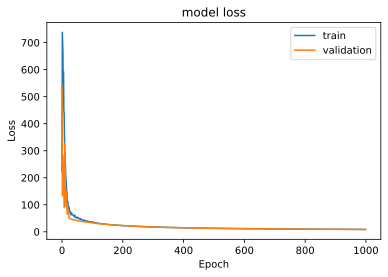

In [13]:
plot_loss(history)

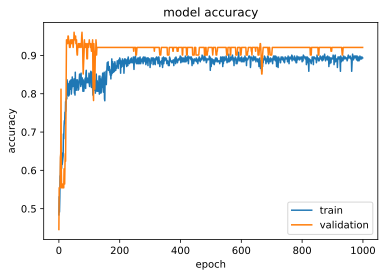

In [14]:
plot_hist(history)

In [15]:
# evaluate the model
train_loss, train_acc = model.evaluate([X_img_train, X_audio_train], y_train, verbose=0)
test_loss, test_acc = model.evaluate([X_img_test, X_audio_test], y_test, verbose=0)
print('Train_Loss: %.3f, Train_Acc: %.3f' % (train_loss, train_acc))
print('Test_Loss: %.3f, Test_Acc: %.3f' % (test_loss, test_acc))

Train_Loss: 8.853, Train_Acc: 0.876
Test_Loss: 8.615, Test_Acc: 0.921


In [16]:
pred = model.predict([X_img_test, X_audio_test])

In [17]:
y_pred = (model.predict([X_img_test, X_audio_test]) > 0.5)*1    #.astype("int32")

In [18]:
#y_pred = np.zeros(pred.shape)
#y_pred[pred>0.5]=1
#y_pred = np.array(y_pred)

In [19]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
score = accuracy_score(y_test, y_pred)
precision = precision_score(y_test,y_pred)
recall = recall_score(y_test,y_pred)
f1 = f1_score(y_test,y_pred)
print("score:", score)
print("Precision:", precision)
print("Recall:", recall)
print("F1_score:", f1)

score: 0.9207920792079208
Precision: 0.8490566037735849
Recall: 1.0
F1_score: 0.9183673469387755


In [20]:
# confusion matrix
matrix = confusion_matrix(y_test, y_pred, labels=[0,1])
print('Confusion matrix : \n',matrix)


Confusion matrix : 
 [[48  8]
 [ 0 45]]


In [21]:
# classification report for precision, recall f1-score and accuracy
matrix = classification_report(y_test, y_pred, labels=[0,1])
print('Classification report : \n',matrix)

Classification report : 
               precision    recall  f1-score   support

           0       1.00      0.86      0.92        56
           1       0.85      1.00      0.92        45

    accuracy                           0.92       101
   macro avg       0.92      0.93      0.92       101
weighted avg       0.93      0.92      0.92       101



In [22]:
# outcome values order in sklearn
tp, fn, fp, tn = confusion_matrix(y_test, y_pred,labels=[0,1]).reshape(-1)
print('Outcome values : \n', tp, fn, fp, tn)

Outcome values : 
 48 8 0 45


In [6]:
from keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten, concatenate
from keras.models import Model
import numpy as np
from keras import regularizers
from keras.layers import Dropout 
def compile_model():
    img_input = Input(shape=(50177,)) 
    ## branch 1 with image input
    x = Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01))(img_input)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = Dropout(0.3)(x)
    out_a = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    out_a = Dense(1, activation='sigmoid')(out_a)
    model = Model(img_input, out_a)
    adam = Adam(lr=0.001, decay=1e-5)
    print(model.summary())
    model.compile(loss="binary_crossentropy", optimizer=adam, metrics=["accuracy"])
    return model
    #x = MaxPooling2D((2, 2))(x)
    #x = Flatten()(x)
    #out_a = Dense(64)(x)

    

In [7]:
model = compile_model()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50177)]           0         
_________________________________________________________________
dense (Dense)                (None, 1024)              51382272  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0     

In [8]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
history=model.fit(X_img_train, y_img_train, batch_size=256, epochs=1000,
                            validation_data=(X_img_test, y_img_test), callbacks=[es])

Epoch 1/1000
2/2 [==============================] - 5s 1s/step - loss: 404.3137 - accuracy: 0.5136 - val_loss: 965.5544 - val_accuracy: 0.4455
Epoch 2/1000
2/2 [==============================] - 1s 497ms/step - loss: 860.1316 - accuracy: 0.5484 - val_loss: 407.7807 - val_accuracy: 0.4455
Epoch 3/1000
2/2 [==============================] - 1s 352ms/step - loss: 897.5616 - accuracy: 0.4839 - val_loss: 388.8131 - val_accuracy: 0.4455
Epoch 4/1000
2/2 [==============================] - 1s 425ms/step - loss: 817.1490 - accuracy: 0.4516 - val_loss: 407.8835 - val_accuracy: 0.4455
Epoch 5/1000
2/2 [==============================] - 1s 503ms/step - loss: 719.4017 - accuracy: 0.5037 - val_loss: 323.6693 - val_accuracy: 0.4455
Epoch 6/1000
2/2 [==============================] - 1s 542ms/step - loss: 645.7780 - accuracy: 0.5434 - val_loss: 185.8350 - val_accuracy: 0.4455
Epoch 7/1000
2/2 [==============================] - 1s 582ms/step - loss: 510.5396 - accuracy: 0.5310 - val_loss: 162.0163 - va

2/2 [==============================] - 1s 514ms/step - loss: 27.4179 - accuracy: 0.5409 - val_loss: 27.3305 - val_accuracy: 0.5347
Epoch 114/1000
2/2 [==============================] - 1s 447ms/step - loss: 27.3128 - accuracy: 0.5409 - val_loss: 27.2331 - val_accuracy: 0.4257
Epoch 115/1000
2/2 [==============================] - 1s 312ms/step - loss: 27.2439 - accuracy: 0.5012 - val_loss: 27.1093 - val_accuracy: 0.5446
Epoch 116/1000
2/2 [==============================] - 1s 407ms/step - loss: 27.1046 - accuracy: 0.5335 - val_loss: 27.0021 - val_accuracy: 0.6040
Epoch 117/1000
2/2 [==============================] - 1s 491ms/step - loss: 26.9887 - accuracy: 0.4814 - val_loss: 26.8975 - val_accuracy: 0.5446
Epoch 118/1000
2/2 [==============================] - 1s 515ms/step - loss: 26.8763 - accuracy: 0.5360 - val_loss: 26.7929 - val_accuracy: 0.5446
Epoch 119/1000
2/2 [==============================] - 1s 455ms/step - loss: 26.7748 - accuracy: 0.5360 - val_loss: 26.6895 - val_accuracy: 

2/2 [==============================] - 1s 418ms/step - loss: 18.5846 - accuracy: 0.5385 - val_loss: 18.5450 - val_accuracy: 0.5545
Epoch 226/1000
2/2 [==============================] - 1s 311ms/step - loss: 18.5390 - accuracy: 0.5360 - val_loss: 18.5030 - val_accuracy: 0.5545
Epoch 227/1000
2/2 [==============================] - 1s 478ms/step - loss: 18.4948 - accuracy: 0.5385 - val_loss: 18.4606 - val_accuracy: 0.5446
Epoch 228/1000
2/2 [==============================] - 1s 412ms/step - loss: 18.4630 - accuracy: 0.5385 - val_loss: 18.4203 - val_accuracy: 0.5545
Epoch 229/1000
2/2 [==============================] - 1s 500ms/step - loss: 18.4141 - accuracy: 0.5360 - val_loss: 18.3780 - val_accuracy: 0.5545
Epoch 230/1000
2/2 [==============================] - 1s 447ms/step - loss: 18.3713 - accuracy: 0.5360 - val_loss: 18.3326 - val_accuracy: 0.5545
Epoch 231/1000
2/2 [==============================] - 1s 293ms/step - loss: 18.3250 - accuracy: 0.5360 - val_loss: 18.2828 - val_accuracy: 

2/2 [==============================] - 1s 597ms/step - loss: 13.6044 - accuracy: 0.5360 - val_loss: 13.5713 - val_accuracy: 0.5545
Epoch 338/1000
2/2 [==============================] - 1s 522ms/step - loss: 13.5695 - accuracy: 0.5310 - val_loss: 13.5350 - val_accuracy: 0.5545
Epoch 339/1000
2/2 [==============================] - 1s 493ms/step - loss: 13.5312 - accuracy: 0.5360 - val_loss: 13.5004 - val_accuracy: 0.5545
Epoch 340/1000
2/2 [==============================] - 1s 297ms/step - loss: 13.4968 - accuracy: 0.5360 - val_loss: 13.4667 - val_accuracy: 0.5545
Epoch 341/1000
2/2 [==============================] - 1s 364ms/step - loss: 13.4632 - accuracy: 0.5360 - val_loss: 13.4334 - val_accuracy: 0.5545
Epoch 342/1000
2/2 [==============================] - 1s 523ms/step - loss: 13.4300 - accuracy: 0.5360 - val_loss: 13.4002 - val_accuracy: 0.5545
Epoch 343/1000
2/2 [==============================] - 1s 558ms/step - loss: 13.3969 - accuracy: 0.5360 - val_loss: 13.3670 - val_accuracy: 

2/2 [==============================] - 1s 496ms/step - loss: 10.9925 - accuracy: 0.5285 - val_loss: 10.9621 - val_accuracy: 0.5545
Epoch 450/1000
2/2 [==============================] - 1s 502ms/step - loss: 10.9585 - accuracy: 0.5459 - val_loss: 10.9346 - val_accuracy: 0.5545
Epoch 451/1000
2/2 [==============================] - 1s 535ms/step - loss: 10.9322 - accuracy: 0.5360 - val_loss: 10.9080 - val_accuracy: 0.5545
Epoch 452/1000
2/2 [==============================] - 1s 514ms/step - loss: 10.9326 - accuracy: 0.5533 - val_loss: 10.8824 - val_accuracy: 0.5545
Epoch 453/1000
2/2 [==============================] - 1s 373ms/step - loss: 10.8813 - accuracy: 0.5360 - val_loss: 10.8622 - val_accuracy: 0.5545
Epoch 454/1000
2/2 [==============================] - 1s 307ms/step - loss: 10.8616 - accuracy: 0.5360 - val_loss: 10.8454 - val_accuracy: 0.5545
Epoch 455/1000
2/2 [==============================] - 1s 416ms/step - loss: 10.8451 - accuracy: 0.5360 - val_loss: 10.8296 - val_accuracy: 

Epoch 562/1000
2/2 [==============================] - 1s 525ms/step - loss: 9.4348 - accuracy: 0.5360 - val_loss: 9.4245 - val_accuracy: 0.5545
Epoch 563/1000
2/2 [==============================] - 1s 533ms/step - loss: 9.4255 - accuracy: 0.5360 - val_loss: 9.4149 - val_accuracy: 0.5545
Epoch 564/1000
2/2 [==============================] - 1s 531ms/step - loss: 9.4159 - accuracy: 0.5360 - val_loss: 9.4057 - val_accuracy: 0.5545
Epoch 565/1000
2/2 [==============================] - 1s 562ms/step - loss: 9.4068 - accuracy: 0.5360 - val_loss: 9.3959 - val_accuracy: 0.5545
Epoch 566/1000
2/2 [==============================] - 1s 344ms/step - loss: 9.3965 - accuracy: 0.5360 - val_loss: 9.3845 - val_accuracy: 0.5545
Epoch 567/1000
2/2 [==============================] - 1s 299ms/step - loss: 9.3848 - accuracy: 0.5360 - val_loss: 9.3714 - val_accuracy: 0.5545
Epoch 568/1000
2/2 [==============================] - 1s 482ms/step - loss: 9.3716 - accuracy: 0.5360 - val_loss: 9.3570 - val_accuracy:

Epoch 619/1000
2/2 [==============================] - 1s 523ms/step - loss: 8.8776 - accuracy: 0.5360 - val_loss: 8.8730 - val_accuracy: 0.5545
Epoch 620/1000
2/2 [==============================] - 1s 398ms/step - loss: 8.8755 - accuracy: 0.5360 - val_loss: 8.8710 - val_accuracy: 0.5545
Epoch 621/1000
2/2 [==============================] - 1s 316ms/step - loss: 8.8734 - accuracy: 0.5360 - val_loss: 8.8683 - val_accuracy: 0.5545
Epoch 622/1000
2/2 [==============================] - 1s 434ms/step - loss: 8.8703 - accuracy: 0.5360 - val_loss: 8.8644 - val_accuracy: 0.5545
Epoch 623/1000
2/2 [==============================] - 1s 483ms/step - loss: 8.8661 - accuracy: 0.5360 - val_loss: 8.8590 - val_accuracy: 0.5545
Epoch 624/1000
2/2 [==============================] - 1s 481ms/step - loss: 8.8605 - accuracy: 0.5360 - val_loss: 8.8524 - val_accuracy: 0.5545
Epoch 625/1000
2/2 [==============================] - 1s 506ms/step - loss: 8.8536 - accuracy: 0.5360 - val_loss: 8.8446 - val_accuracy:

Epoch 676/1000
2/2 [==============================] - 1s 410ms/step - loss: 8.5145 - accuracy: 0.5360 - val_loss: 8.5069 - val_accuracy: 0.5545
Epoch 677/1000
2/2 [==============================] - 1s 516ms/step - loss: 8.5083 - accuracy: 0.5360 - val_loss: 8.5006 - val_accuracy: 0.5545
Epoch 678/1000
2/2 [==============================] - 1s 478ms/step - loss: 8.5029 - accuracy: 0.5310 - val_loss: 8.4936 - val_accuracy: 0.5545
Epoch 679/1000
2/2 [==============================] - 1s 513ms/step - loss: 8.4921 - accuracy: 0.5385 - val_loss: 8.4873 - val_accuracy: 0.5545
Epoch 680/1000
2/2 [==============================] - 1s 580ms/step - loss: 8.5760 - accuracy: 0.5211 - val_loss: 8.4856 - val_accuracy: 0.5545
Epoch 681/1000
2/2 [==============================] - 1s 385ms/step - loss: 8.4896 - accuracy: 0.5360 - val_loss: 8.4944 - val_accuracy: 0.5545
Epoch 682/1000
2/2 [==============================] - 1s 288ms/step - loss: 8.4992 - accuracy: 0.5360 - val_loss: 8.5065 - val_accuracy:

Epoch 733/1000
2/2 [==============================] - 1s 432ms/step - loss: 8.2545 - accuracy: 0.5335 - val_loss: 8.2865 - val_accuracy: 0.4653
Epoch 734/1000
2/2 [==============================] - 1s 552ms/step - loss: 8.2814 - accuracy: 0.5509 - val_loss: 8.2674 - val_accuracy: 0.5545
Epoch 735/1000
2/2 [==============================] - 1s 480ms/step - loss: 8.2746 - accuracy: 0.5385 - val_loss: 8.2906 - val_accuracy: 0.5545
Epoch 736/1000
2/2 [==============================] - 1s 517ms/step - loss: 8.2979 - accuracy: 0.5360 - val_loss: 8.3141 - val_accuracy: 0.5545
Epoch 737/1000
2/2 [==============================] - 1s 298ms/step - loss: 8.3203 - accuracy: 0.5360 - val_loss: 8.3314 - val_accuracy: 0.5545
Epoch 738/1000
2/2 [==============================] - 1s 304ms/step - loss: 8.3361 - accuracy: 0.5360 - val_loss: 8.3400 - val_accuracy: 0.5545
Epoch 739/1000
2/2 [==============================] - 1s 420ms/step - loss: 8.3431 - accuracy: 0.5360 - val_loss: 8.3399 - val_accuracy:

Epoch 790/1000
2/2 [==============================] - 1s 373ms/step - loss: 8.0371 - accuracy: 0.5360 - val_loss: 8.0511 - val_accuracy: 0.5545
Epoch 791/1000
2/2 [==============================] - 1s 342ms/step - loss: 8.0582 - accuracy: 0.5360 - val_loss: 8.0752 - val_accuracy: 0.5545
Epoch 792/1000
2/2 [==============================] - 1s 463ms/step - loss: 8.0817 - accuracy: 0.5360 - val_loss: 8.0954 - val_accuracy: 0.5545
Epoch 793/1000
2/2 [==============================] - 1s 496ms/step - loss: 8.1006 - accuracy: 0.5360 - val_loss: 8.1078 - val_accuracy: 0.5545
Epoch 794/1000
2/2 [==============================] - 1s 460ms/step - loss: 8.1115 - accuracy: 0.5360 - val_loss: 8.1111 - val_accuracy: 0.5545
Epoch 795/1000
2/2 [==============================] - 1s 476ms/step - loss: 8.1168 - accuracy: 0.5285 - val_loss: 8.1077 - val_accuracy: 0.5545
Epoch 796/1000
2/2 [==============================] - 1s 526ms/step - loss: 8.1128 - accuracy: 0.5335 - val_loss: 8.1089 - val_accuracy:

Epoch 847/1000
2/2 [==============================] - 1s 558ms/step - loss: 7.9092 - accuracy: 0.5360 - val_loss: 7.8957 - val_accuracy: 0.5545
Epoch 848/1000
2/2 [==============================] - 1s 485ms/step - loss: 7.8966 - accuracy: 0.5360 - val_loss: 7.8855 - val_accuracy: 0.5545
Epoch 849/1000
2/2 [==============================] - 1s 542ms/step - loss: 7.8863 - accuracy: 0.5360 - val_loss: 7.8764 - val_accuracy: 0.5545
Epoch 850/1000
2/2 [==============================] - 1s 516ms/step - loss: 7.8854 - accuracy: 0.5161 - val_loss: 7.8655 - val_accuracy: 0.5545
Epoch 851/1000
2/2 [==============================] - 1s 429ms/step - loss: 7.8663 - accuracy: 0.5360 - val_loss: 7.8546 - val_accuracy: 0.5545
Epoch 852/1000
2/2 [==============================] - 1s 309ms/step - loss: 7.8553 - accuracy: 0.5360 - val_loss: 7.8427 - val_accuracy: 0.5545
Epoch 853/1000
2/2 [==============================] - 1s 431ms/step - loss: 7.8432 - accuracy: 0.5360 - val_loss: 7.8294 - val_accuracy:

Epoch 904/1000
2/2 [==============================] - 1s 564ms/step - loss: 7.8213 - accuracy: 0.5161 - val_loss: 7.8619 - val_accuracy: 0.4455
Epoch 905/1000
2/2 [==============================] - 1s 536ms/step - loss: 8.6822 - accuracy: 0.5062 - val_loss: 7.8423 - val_accuracy: 0.5545
Epoch 906/1000
2/2 [==============================] - 1s 309ms/step - loss: 7.8645 - accuracy: 0.5112 - val_loss: 7.8822 - val_accuracy: 0.5545
Epoch 907/1000
2/2 [==============================] - 1s 297ms/step - loss: 7.8949 - accuracy: 0.5360 - val_loss: 7.9381 - val_accuracy: 0.5545
Epoch 908/1000
2/2 [==============================] - 1s 453ms/step - loss: 7.9511 - accuracy: 0.5360 - val_loss: 7.9931 - val_accuracy: 0.5545
Epoch 909/1000
2/2 [==============================] - 1s 512ms/step - loss: 8.0045 - accuracy: 0.5360 - val_loss: 8.0379 - val_accuracy: 0.5545
Epoch 910/1000
2/2 [==============================] - 1s 458ms/step - loss: 8.0469 - accuracy: 0.5360 - val_loss: 8.0684 - val_accuracy:

Epoch 961/1000
2/2 [==============================] - 1s 421ms/step - loss: 7.8571 - accuracy: 0.5360 - val_loss: 7.8448 - val_accuracy: 0.5545
Epoch 962/1000
2/2 [==============================] - 1s 505ms/step - loss: 7.8442 - accuracy: 0.5360 - val_loss: 7.8223 - val_accuracy: 0.6238
Epoch 963/1000
2/2 [==============================] - 1s 503ms/step - loss: 7.8483 - accuracy: 0.5459 - val_loss: 7.8026 - val_accuracy: 0.5545
Epoch 964/1000
2/2 [==============================] - 1s 530ms/step - loss: 7.8013 - accuracy: 0.5360 - val_loss: 7.7810 - val_accuracy: 0.5545
Epoch 965/1000
2/2 [==============================] - 1s 542ms/step - loss: 7.7798 - accuracy: 0.5360 - val_loss: 7.7597 - val_accuracy: 0.5545
Epoch 966/1000
2/2 [==============================] - 1s 422ms/step - loss: 7.7776 - accuracy: 0.5385 - val_loss: 7.7417 - val_accuracy: 0.5545
Epoch 967/1000
2/2 [==============================] - 1s 307ms/step - loss: 7.7436 - accuracy: 0.5360 - val_loss: 7.7401 - val_accuracy:

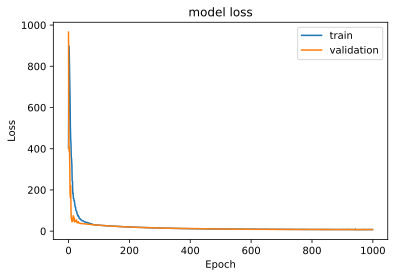

In [11]:
plot_loss(history)

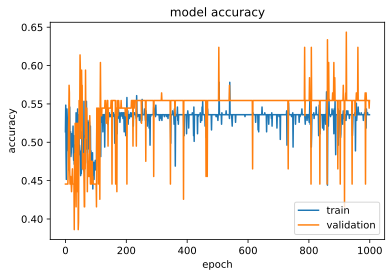

In [12]:
plot_hist(history)

In [13]:
# evaluate the model
train_loss, train_acc = model.evaluate(X_img_train, y_train, verbose=0)
test_loss, test_acc = model.evaluate(X_img_test, y_test, verbose=0)
print('Train_Loss: %.3f, Train_Acc: %.3f' % (train_loss, train_acc))
print('Test_Loss: %.3f, Test_Acc: %.3f' % (test_loss, test_acc))

Train_Loss: 7.779, Train_Acc: 0.536
Test_Loss: 7.777, Test_Acc: 0.554


In [14]:
pred = model.predict(X_img_test)

In [15]:
y_pred = (model.predict(X_img_test) > 0.5)*1    #.astype("int32")

In [16]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
score = accuracy_score(y_test, y_pred)
precision = precision_score(y_test,y_pred)
recall = recall_score(y_test,y_pred)
f1 = f1_score(y_test,y_pred)
print("score:", score)
print("Precision:", precision)
print("Recall:", recall)
print("F1_score:", f1)

score: 0.5544554455445545
Precision: 0.0
Recall: 0.0
F1_score: 0.0


In [17]:
# confusion matrix
matrix = confusion_matrix(y_test, y_pred, labels=[0,1])
print('Confusion matrix : \n',matrix)


Confusion matrix : 
 [[56  0]
 [45  0]]


In [18]:
# classification report for precision, recall f1-score and accuracy
matrix = classification_report(y_test, y_pred, labels=[0,1])
print('Classification report : \n',matrix)

Classification report : 
               precision    recall  f1-score   support

           0       0.55      1.00      0.71        56
           1       0.00      0.00      0.00        45

    accuracy                           0.55       101
   macro avg       0.28      0.50      0.36       101
weighted avg       0.31      0.55      0.40       101



In [64]:
# outcome values order in sklearn
tp, fn, fp, tn = confusion_matrix(y_test, y_pred,labels=[0,1]).reshape(-1)
print('Outcome values : \n', tp, fn, fp, tn)

Outcome values : 
 56 0 45 0


In [40]:
from keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten, concatenate
from keras.models import Model
import numpy as np
from keras import regularizers
from keras.layers import Dropout 
def compile_model():
    num_input = Input(shape=(133,))        ## branch 2 with numerical input
    x1 = Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01))(num_input)
    x1 = Dropout(0.3)(x1)
    x1 = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x1)
    x1 = Dropout(0.3)(x1)
    x1 = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x1)
    x1 = Dropout(0.3)(x1)
    x1 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x1)
    x1 = Dropout(0.3)(x1)
    x1 = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x1)
    x1 = Dropout(0.3)(x1)
    out_b = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x1)
    out_b = Dense(1, activation='sigmoid')(out_b)
    model = Model(num_input, out_b)
    adam = Adam(lr=0.001, decay=1e-5)
    print(model.summary())
    model.compile(loss="binary_crossentropy", optimizer=adam, metrics=["accuracy"])
    return model

In [41]:
model = compile_model()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 133)]             0         
_________________________________________________________________
dense_34 (Dense)             (None, 1024)              137216    
_________________________________________________________________
dropout_25 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_35 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_26 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_27 (Dropout)         (None, 256)               0   

In [42]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
history=model.fit(X_audio_train, y_audio_train, batch_size=256, epochs=1000,
                            validation_data=(X_audio_test, y_audio_test), callbacks=[es])

Epoch 1/1000
2/2 [==============================] - 1s 217ms/step - loss: 58.6776 - accuracy: 0.5682 - val_loss: 31.4306 - val_accuracy: 0.4950
Epoch 2/1000
2/2 [==============================] - 0s 40ms/step - loss: 40.8605 - accuracy: 0.4938 - val_loss: 21.7985 - val_accuracy: 0.5347
Epoch 3/1000
2/2 [==============================] - 0s 38ms/step - loss: 39.2529 - accuracy: 0.5360 - val_loss: 30.6041 - val_accuracy: 0.4950
Epoch 4/1000
2/2 [==============================] - 0s 37ms/step - loss: 39.8596 - accuracy: 0.4516 - val_loss: 19.5230 - val_accuracy: 0.4950
Epoch 5/1000
2/2 [==============================] - 0s 36ms/step - loss: 31.5472 - accuracy: 0.4839 - val_loss: 23.9285 - val_accuracy: 0.5050
Epoch 6/1000
2/2 [==============================] - 0s 38ms/step - loss: 27.1815 - accuracy: 0.5509 - val_loss: 23.4637 - val_accuracy: 0.5050
Epoch 7/1000
2/2 [==============================] - 0s 37ms/step - loss: 25.8422 - accuracy: 0.5434 - val_loss: 16.9530 - val_accuracy: 0.505

Epoch 116/1000
2/2 [==============================] - 0s 39ms/step - loss: 7.7166 - accuracy: 0.9355 - val_loss: 7.5735 - val_accuracy: 0.9802
Epoch 117/1000
2/2 [==============================] - 0s 37ms/step - loss: 7.6979 - accuracy: 0.9454 - val_loss: 7.5529 - val_accuracy: 0.9901
Epoch 118/1000
2/2 [==============================] - 0s 38ms/step - loss: 7.7119 - accuracy: 0.9429 - val_loss: 7.5375 - val_accuracy: 0.9901
Epoch 119/1000
2/2 [==============================] - 0s 37ms/step - loss: 7.6661 - accuracy: 0.9404 - val_loss: 7.5276 - val_accuracy: 0.9802
Epoch 120/1000
2/2 [==============================] - 0s 38ms/step - loss: 7.5886 - accuracy: 0.9603 - val_loss: 7.5231 - val_accuracy: 0.9802
Epoch 121/1000
2/2 [==============================] - 0s 37ms/step - loss: 7.6239 - accuracy: 0.9504 - val_loss: 7.5053 - val_accuracy: 0.9802
Epoch 122/1000
2/2 [==============================] - 0s 37ms/step - loss: 7.6109 - accuracy: 0.9479 - val_loss: 7.4881 - val_accuracy: 0.9802

2/2 [==============================] - 0s 37ms/step - loss: 5.8140 - accuracy: 0.9826 - val_loss: 5.8038 - val_accuracy: 0.9901
Epoch 231/1000
2/2 [==============================] - 0s 37ms/step - loss: 5.7957 - accuracy: 0.9876 - val_loss: 5.7978 - val_accuracy: 0.9802
Epoch 232/1000
2/2 [==============================] - 0s 37ms/step - loss: 5.8016 - accuracy: 0.9801 - val_loss: 5.7752 - val_accuracy: 0.9901
Epoch 233/1000
2/2 [==============================] - 0s 36ms/step - loss: 5.7750 - accuracy: 0.9777 - val_loss: 5.7573 - val_accuracy: 0.9901
Epoch 234/1000
2/2 [==============================] - 0s 38ms/step - loss: 5.7820 - accuracy: 0.9851 - val_loss: 5.7499 - val_accuracy: 0.9901
Epoch 235/1000
2/2 [==============================] - 0s 37ms/step - loss: 5.7305 - accuracy: 0.9926 - val_loss: 5.7448 - val_accuracy: 0.9901
Epoch 236/1000
2/2 [==============================] - 0s 37ms/step - loss: 5.7388 - accuracy: 0.9901 - val_loss: 5.7381 - val_accuracy: 0.9802
Epoch 237/1000

2/2 [==============================] - 0s 37ms/step - loss: 4.5187 - accuracy: 0.9801 - val_loss: 4.4853 - val_accuracy: 0.9901
Epoch 345/1000
2/2 [==============================] - 0s 38ms/step - loss: 4.5170 - accuracy: 0.9851 - val_loss: 4.4801 - val_accuracy: 0.9901
Epoch 346/1000
2/2 [==============================] - 0s 37ms/step - loss: 4.5251 - accuracy: 0.9777 - val_loss: 4.4718 - val_accuracy: 0.9901
Epoch 347/1000
2/2 [==============================] - 0s 38ms/step - loss: 4.4840 - accuracy: 0.9752 - val_loss: 4.4592 - val_accuracy: 0.9901
Epoch 348/1000
2/2 [==============================] - 0s 36ms/step - loss: 4.4610 - accuracy: 0.9975 - val_loss: 4.4449 - val_accuracy: 0.9901
Epoch 349/1000
2/2 [==============================] - 0s 37ms/step - loss: 4.4612 - accuracy: 0.9826 - val_loss: 4.4322 - val_accuracy: 0.9901
Epoch 350/1000
2/2 [==============================] - 0s 38ms/step - loss: 4.4325 - accuracy: 0.9926 - val_loss: 4.4323 - val_accuracy: 0.9901
Epoch 351/1000

2/2 [==============================] - 0s 37ms/step - loss: 3.5131 - accuracy: 0.9752 - val_loss: 3.4818 - val_accuracy: 0.9901
Epoch 459/1000
2/2 [==============================] - 0s 36ms/step - loss: 3.4780 - accuracy: 0.9926 - val_loss: 3.4914 - val_accuracy: 0.9802
Epoch 460/1000
2/2 [==============================] - 0s 38ms/step - loss: 3.5023 - accuracy: 0.9851 - val_loss: 3.4954 - val_accuracy: 0.9802
Epoch 461/1000
2/2 [==============================] - 0s 37ms/step - loss: 3.5026 - accuracy: 0.9851 - val_loss: 3.4637 - val_accuracy: 0.9901
Epoch 462/1000
2/2 [==============================] - 0s 36ms/step - loss: 3.4616 - accuracy: 0.9876 - val_loss: 3.4483 - val_accuracy: 0.9901
Epoch 463/1000
2/2 [==============================] - 0s 37ms/step - loss: 3.4866 - accuracy: 0.9851 - val_loss: 3.4398 - val_accuracy: 0.9901
Epoch 464/1000
2/2 [==============================] - 0s 38ms/step - loss: 3.4474 - accuracy: 0.9901 - val_loss: 3.4338 - val_accuracy: 0.9901
Epoch 465/1000

2/2 [==============================] - 0s 37ms/step - loss: 2.7007 - accuracy: 0.9926 - val_loss: 2.7108 - val_accuracy: 0.9901
Epoch 573/1000
2/2 [==============================] - 0s 38ms/step - loss: 2.7246 - accuracy: 0.9876 - val_loss: 2.7020 - val_accuracy: 0.9901
Epoch 574/1000
2/2 [==============================] - 0s 37ms/step - loss: 2.6956 - accuracy: 0.9876 - val_loss: 2.6898 - val_accuracy: 0.9901
Epoch 575/1000
2/2 [==============================] - 0s 37ms/step - loss: 2.6885 - accuracy: 0.9926 - val_loss: 2.6817 - val_accuracy: 0.9901
Epoch 576/1000
2/2 [==============================] - 0s 37ms/step - loss: 2.7022 - accuracy: 0.9851 - val_loss: 2.6821 - val_accuracy: 0.9901
Epoch 577/1000
2/2 [==============================] - 0s 38ms/step - loss: 2.6964 - accuracy: 0.9876 - val_loss: 2.6951 - val_accuracy: 0.9802
Epoch 578/1000
2/2 [==============================] - 0s 37ms/step - loss: 2.6871 - accuracy: 0.9901 - val_loss: 2.6966 - val_accuracy: 0.9802
Epoch 579/1000

2/2 [==============================] - 0s 38ms/step - loss: 2.1158 - accuracy: 0.9901 - val_loss: 2.1034 - val_accuracy: 0.9901
Epoch 687/1000
2/2 [==============================] - 0s 37ms/step - loss: 2.1130 - accuracy: 0.9851 - val_loss: 2.1097 - val_accuracy: 0.9802
Epoch 688/1000
2/2 [==============================] - 0s 37ms/step - loss: 2.0938 - accuracy: 0.9950 - val_loss: 2.1011 - val_accuracy: 0.9901
Epoch 689/1000
2/2 [==============================] - 0s 38ms/step - loss: 2.1122 - accuracy: 0.9876 - val_loss: 2.0828 - val_accuracy: 0.9901
Epoch 690/1000
2/2 [==============================] - 0s 38ms/step - loss: 2.1061 - accuracy: 0.9901 - val_loss: 2.0772 - val_accuracy: 0.9901
Epoch 691/1000
2/2 [==============================] - 0s 37ms/step - loss: 2.0944 - accuracy: 0.9851 - val_loss: 2.0787 - val_accuracy: 0.9901
Epoch 692/1000
2/2 [==============================] - 0s 38ms/step - loss: 2.0839 - accuracy: 0.9876 - val_loss: 2.0979 - val_accuracy: 0.9802
Epoch 693/1000

2/2 [==============================] - 0s 39ms/step - loss: 1.6463 - accuracy: 0.9876 - val_loss: 1.6474 - val_accuracy: 0.9901
Epoch 801/1000
2/2 [==============================] - 0s 37ms/step - loss: 1.6406 - accuracy: 0.9876 - val_loss: 1.6782 - val_accuracy: 0.9802
Epoch 802/1000
2/2 [==============================] - 0s 37ms/step - loss: 1.6543 - accuracy: 0.9851 - val_loss: 1.6449 - val_accuracy: 0.9802
Epoch 803/1000
2/2 [==============================] - 0s 39ms/step - loss: 1.6391 - accuracy: 0.9876 - val_loss: 1.6145 - val_accuracy: 0.9901
Epoch 804/1000
2/2 [==============================] - 0s 38ms/step - loss: 1.6366 - accuracy: 0.9826 - val_loss: 1.6109 - val_accuracy: 1.0000
Epoch 805/1000
2/2 [==============================] - 0s 38ms/step - loss: 1.6417 - accuracy: 0.9777 - val_loss: 1.6250 - val_accuracy: 0.9901
Epoch 806/1000
2/2 [==============================] - 0s 37ms/step - loss: 1.6234 - accuracy: 0.9876 - val_loss: 1.6805 - val_accuracy: 0.9802
Epoch 807/1000

2/2 [==============================] - 0s 38ms/step - loss: 1.2626 - accuracy: 0.9926 - val_loss: 1.2583 - val_accuracy: 0.9901
Epoch 915/1000
2/2 [==============================] - 0s 37ms/step - loss: 1.2753 - accuracy: 0.9851 - val_loss: 1.2513 - val_accuracy: 0.9901
Epoch 916/1000
2/2 [==============================] - 0s 38ms/step - loss: 1.2702 - accuracy: 0.9851 - val_loss: 1.2562 - val_accuracy: 0.9901
Epoch 917/1000
2/2 [==============================] - 0s 36ms/step - loss: 1.2598 - accuracy: 0.9876 - val_loss: 1.2649 - val_accuracy: 0.9901
Epoch 918/1000
2/2 [==============================] - 0s 38ms/step - loss: 1.2668 - accuracy: 0.9901 - val_loss: 1.2603 - val_accuracy: 0.9901
Epoch 919/1000
2/2 [==============================] - 0s 37ms/step - loss: 1.2630 - accuracy: 0.9876 - val_loss: 1.2569 - val_accuracy: 0.9901
Epoch 920/1000
2/2 [==============================] - 0s 36ms/step - loss: 1.2549 - accuracy: 0.9926 - val_loss: 1.2555 - val_accuracy: 0.9901
Epoch 921/1000

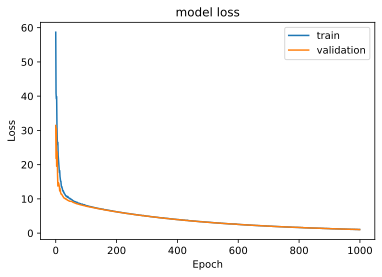

In [43]:
plot_loss(history)

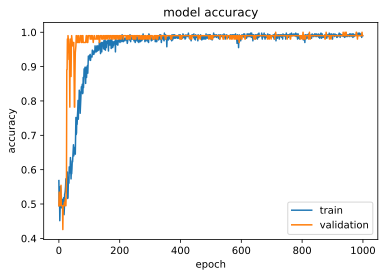

In [44]:
plot_hist(history)

In [45]:
# evaluate the model
train_loss, train_acc = model.evaluate(X_audio_train, y_audio_train, verbose=0)
test_loss, test_acc = model.evaluate(X_audio_test, y_audio_test, verbose=0)
print('Train_Loss: %.3f, Train_Acc: %.3f' % (train_loss, train_acc))
print('Test_Loss: %.3f, Test_Acc: %.3f' % (test_loss, test_acc))

Train_Loss: 1.034, Train_Acc: 0.995
Test_Loss: 1.037, Test_Acc: 0.990


In [46]:
pred = model.predict(X_audio_test)

In [48]:
y_pred = (model.predict(X_audio_test) > 0.5)*1

In [49]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
score = accuracy_score(y_audio_test, y_pred)
precision = precision_score(y_audio_test,y_pred)
recall = recall_score(y_audio_test,y_pred)
f1 = f1_score(y_audio_test,y_pred)
print("score:", score)
print("Precision:", precision)
print("Recall:", recall)
print("F1_score:", f1)

score: 0.9900990099009901
Precision: 1.0
Recall: 0.98
F1_score: 0.98989898989899


In [50]:
# confusion matrix
matrix = confusion_matrix(y_audio_test, y_pred, labels=[0,1])
print('Confusion matrix : \n',matrix)

Confusion matrix : 
 [[51  0]
 [ 1 49]]


In [51]:
# classification report for precision, recall f1-score and accuracy
matrix = classification_report(y_audio_test, y_pred, labels=[0,1])
print('Classification report : \n',matrix)

Classification report : 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99        51
           1       1.00      0.98      0.99        50

    accuracy                           0.99       101
   macro avg       0.99      0.99      0.99       101
weighted avg       0.99      0.99      0.99       101



In [52]:
# outcome values order in sklearn
tp, fn, fp, tn = confusion_matrix(y_audio_test, y_pred,labels=[0,1]).reshape(-1)
print('Outcome values : \n', tp, fn, fp, tn)

Outcome values : 
 51 0 1 49
